# 1. Setup

In [1]:
# TODO: clean this up
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm
import re
import string
import nltk
import torch
import transformers as ppb
from nltk import pos_tag, download
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from math import ceil
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [3]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 1 - TRAIN_RATIO
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1
EVALUATION_METRICS = ['precision', 'recall', 'f1-score']


In [4]:
results = []

# 2. Filtering & EDA

### 2.0. Function definitions & variables

In [5]:
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str], fig_size: tuple[int, int] = (15, 30), y_max: float = 0.35):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)

    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # initalize axes to plot the 7 sub-groups in two rows of 3 and a last row of 1
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=fig_size)
    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for ax, col in zip(axes.flatten(), target_cols):

        # Calculate the number of observations with a non-zero value for the target column
        non_zero_count = hate_speech_df[col].value_counts()[1]

        # identify all columns in the dataframe that starts with the target column name
        sub_groups_column_names = [column for column in df.columns if column.startswith(col)]

        # remove the original target column from the list
        sub_groups_column_names.remove(col)
        col_name = col.replace("target_", "").title()

        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups_column_names].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # remove the col string from the labels
        labels = sub_group_means.index.str.replace((col + "_"), '')

        # plot on the specific axis
        sub_group_means.plot(kind='bar', ax=ax)
        ax.set_xticklabels(labels)
        ax.set_title(f'Percentage of hate speech targeting {col_name} by sub-group \n(n={non_zero_count})')
        ax.set_xlabel('Sub-group')
        ax.set_ylabel('Percentage of hate speech')
        ax.set_ylim(0, y_max)
    
    plt.subplots_adjust(hspace=0.7)

def inspect_for_cor(df, columns: list[str], plot_label: str, hate_speech_only: bool = True):

    # filter for hate speech only if specified
    if hate_speech_only:
        df = df[df['is_hate_speech'] == 1]
    
    # Make a correlation matrix
    corr_matrix = df[columns].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {plot_label}')
    plt.show()

    # Make a pairplot of the columns
    sns.pairplot(df[columns])
    plt.title(f'Pairplot for {plot_label}')
    plt.show()


In [6]:
aspect_cols = [
    'insult',
    'humiliate',
    'status',
    'dehumanize',
    'violence',
    'genocide'
]

target_cols_lvl1_and_2 = [col for col in df_raw.columns if col.startswith('target_')]

target_cols_lvl1 = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]

cols_to_keep = [
    'comment_id', 
    'text', 
    'hate_speech_score',
    *aspect_cols,
    *target_cols_lvl1_and_2
]


### 2.1. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


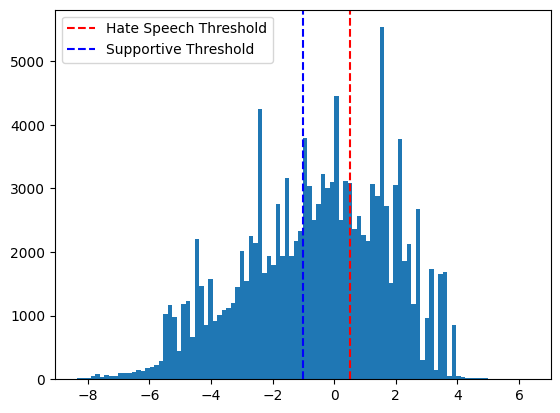

In [7]:
plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.2. Filtering & reformating

TODO: Make list of filtering actions for report 


In [8]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,Yes indeed. She sort of reminds me of the elde...
1,39773,The trans women reading this tweet right now i...
2,47101,Question: These 4 broads who criticize America...
3,43625,It is about time for all illegals to go back t...
4,12538,For starters bend over the one in pink and kic...


In [9]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [10]:
# Step 1: Select relevant columns
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [11]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [12]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [13]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,insult,humiliate,status,dehumanize,violence,genocide,target_race_asian,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,2.451707,2.170926,2.560852,1.700071,0.825427,0.448814,0.036070,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,1.185507,1.147433,0.699245,1.098025,1.000165,0.765847,0.161093,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,1.666667,1.333333,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,3.000000,2.333333,2.500000,1.666667,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,3.333333,3.000000,3.000000,2.500000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   insult                                 39565 non-null  float64
 5   humiliate                              39565 non-null  float64
 6   status                                 39565 non-null  float64
 7   dehumanize                             39565 non-null  float64
 8   violence                               39565 non-null  float64
 9   genocide                               39565 non-null  float64
 10  target_race_asian                      39565 non-null  float64
 11  ta

### 2.3. Post-filtering EDA

Total count: 39565
Supportive count: 17475 (44.17%)
Hate count: 10354 (26.17%)
Neutral count: 11736 (29.66%)


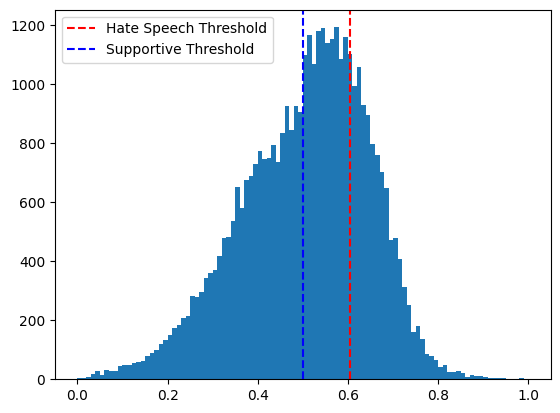

In [15]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

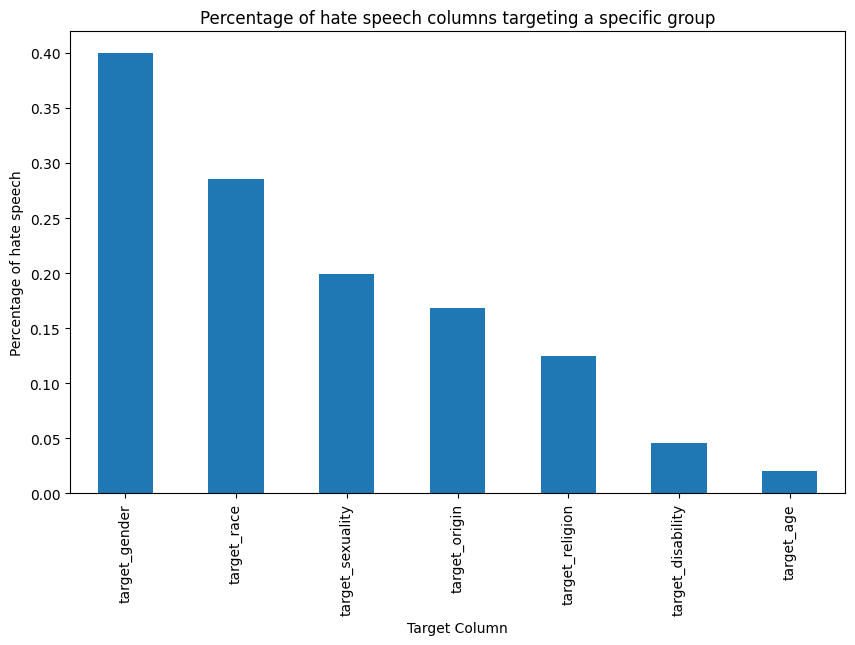

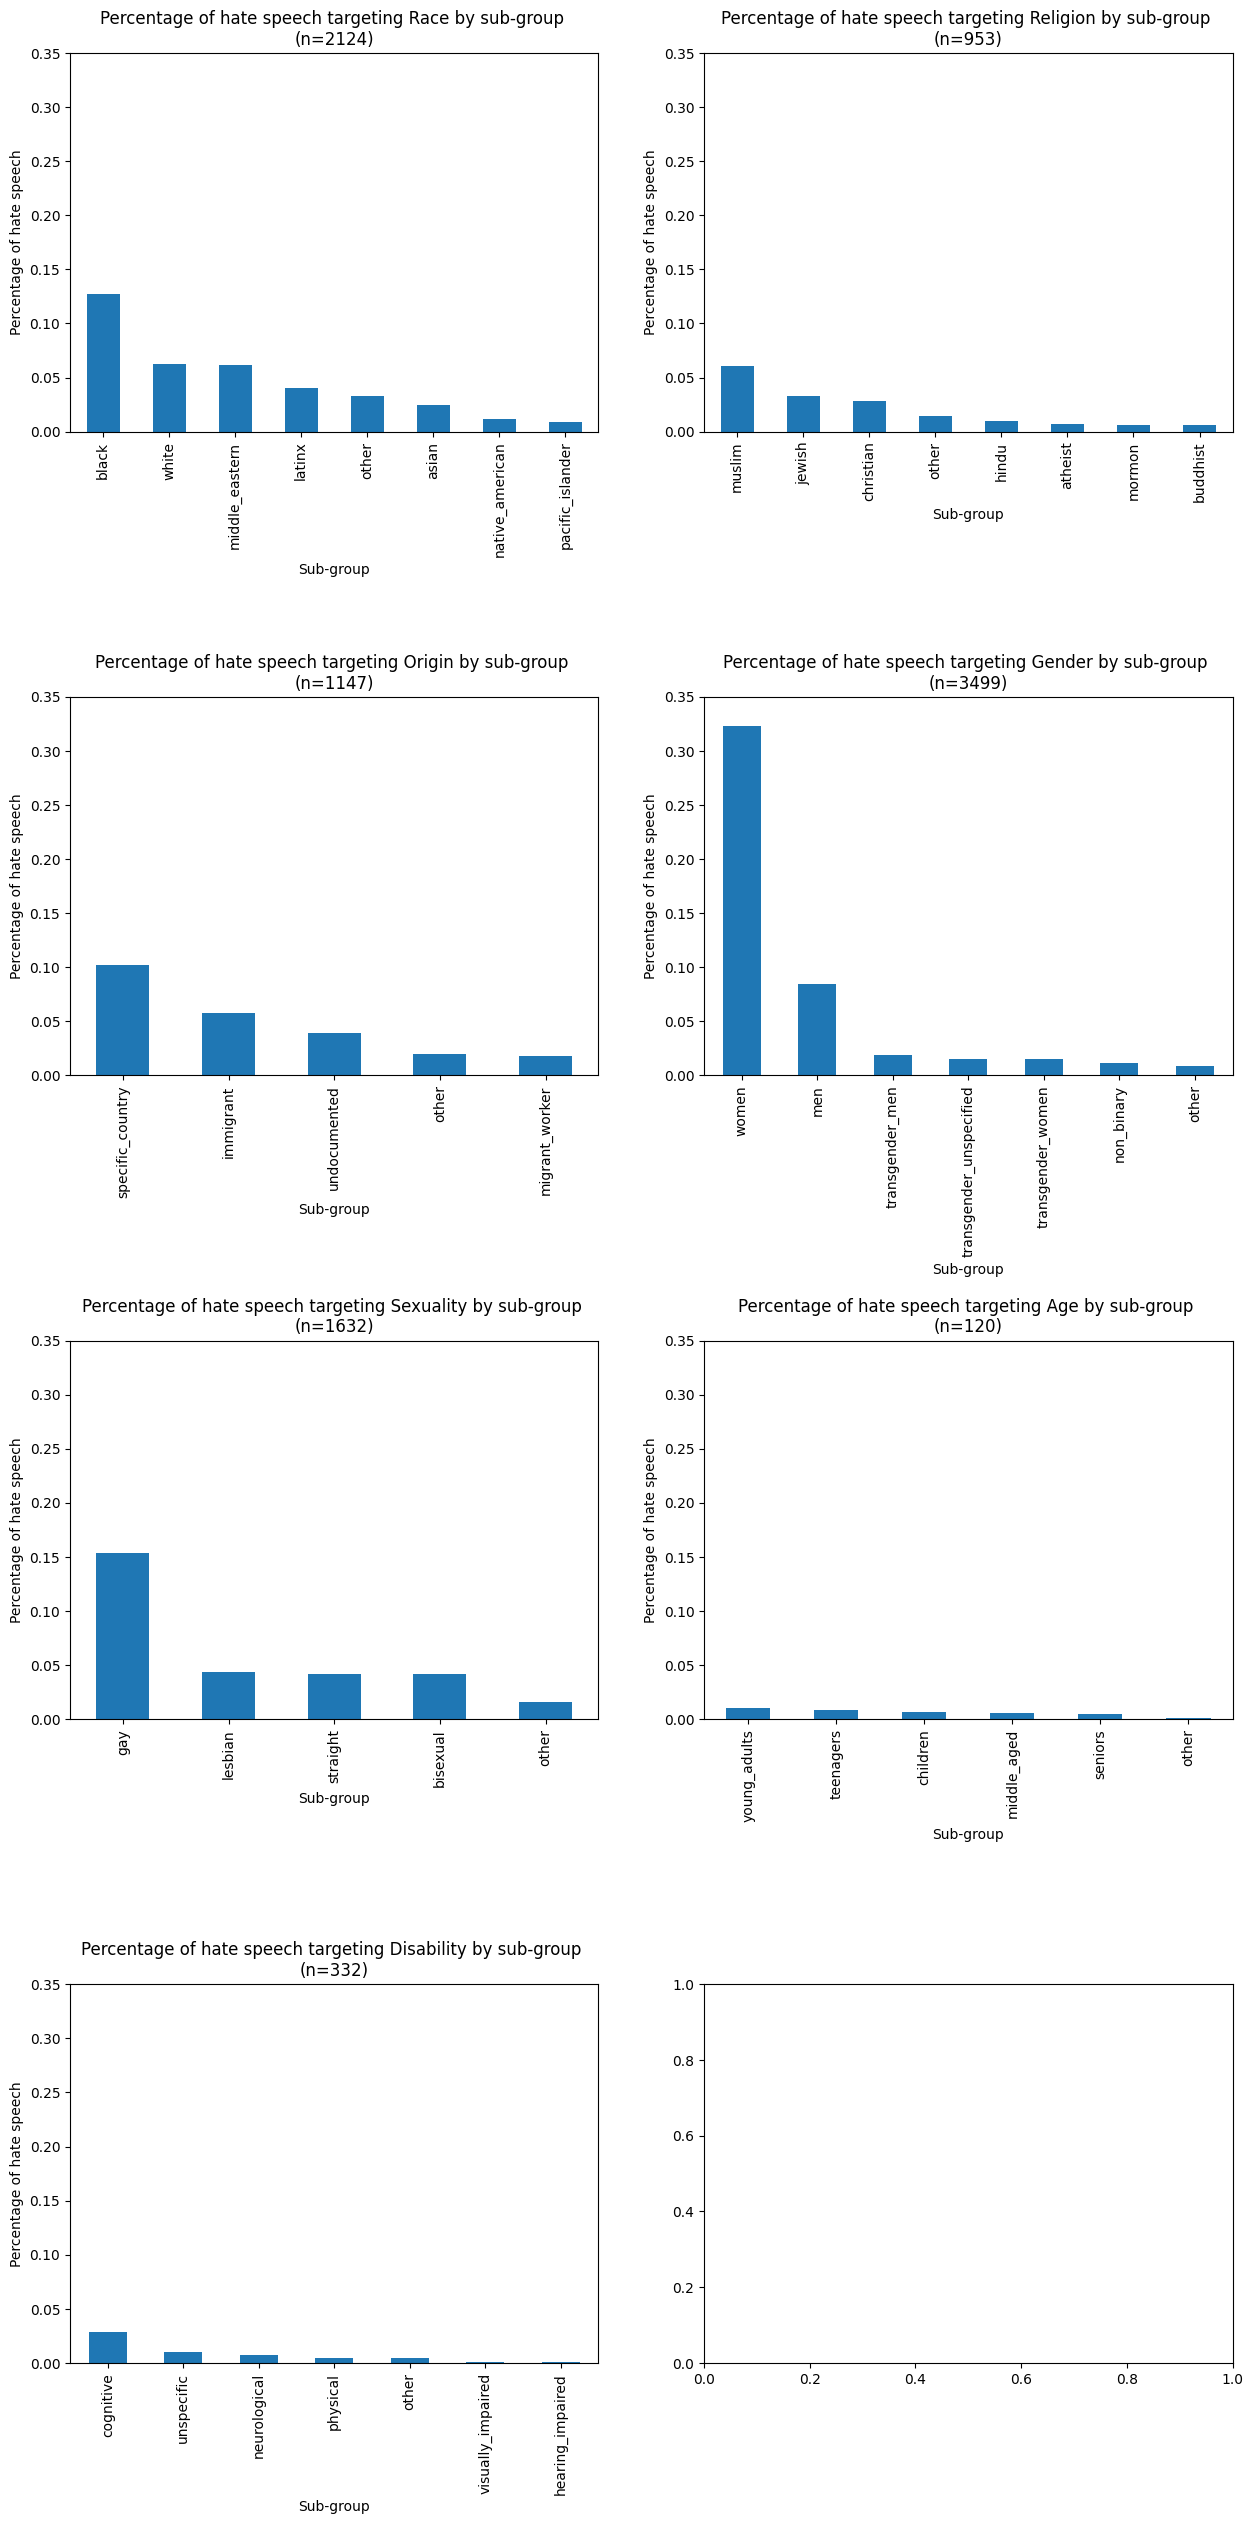

In [16]:
plot_target_columns_distribution(filtered_df, target_cols_lvl1)
plot_target_columns_detailed(filtered_df, target_cols_lvl1)

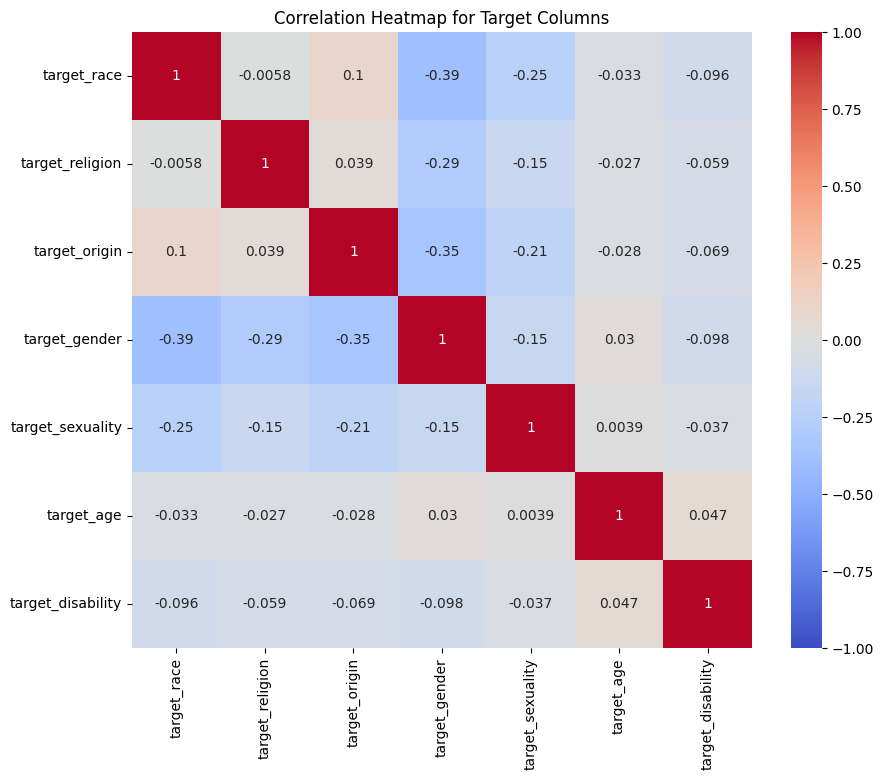

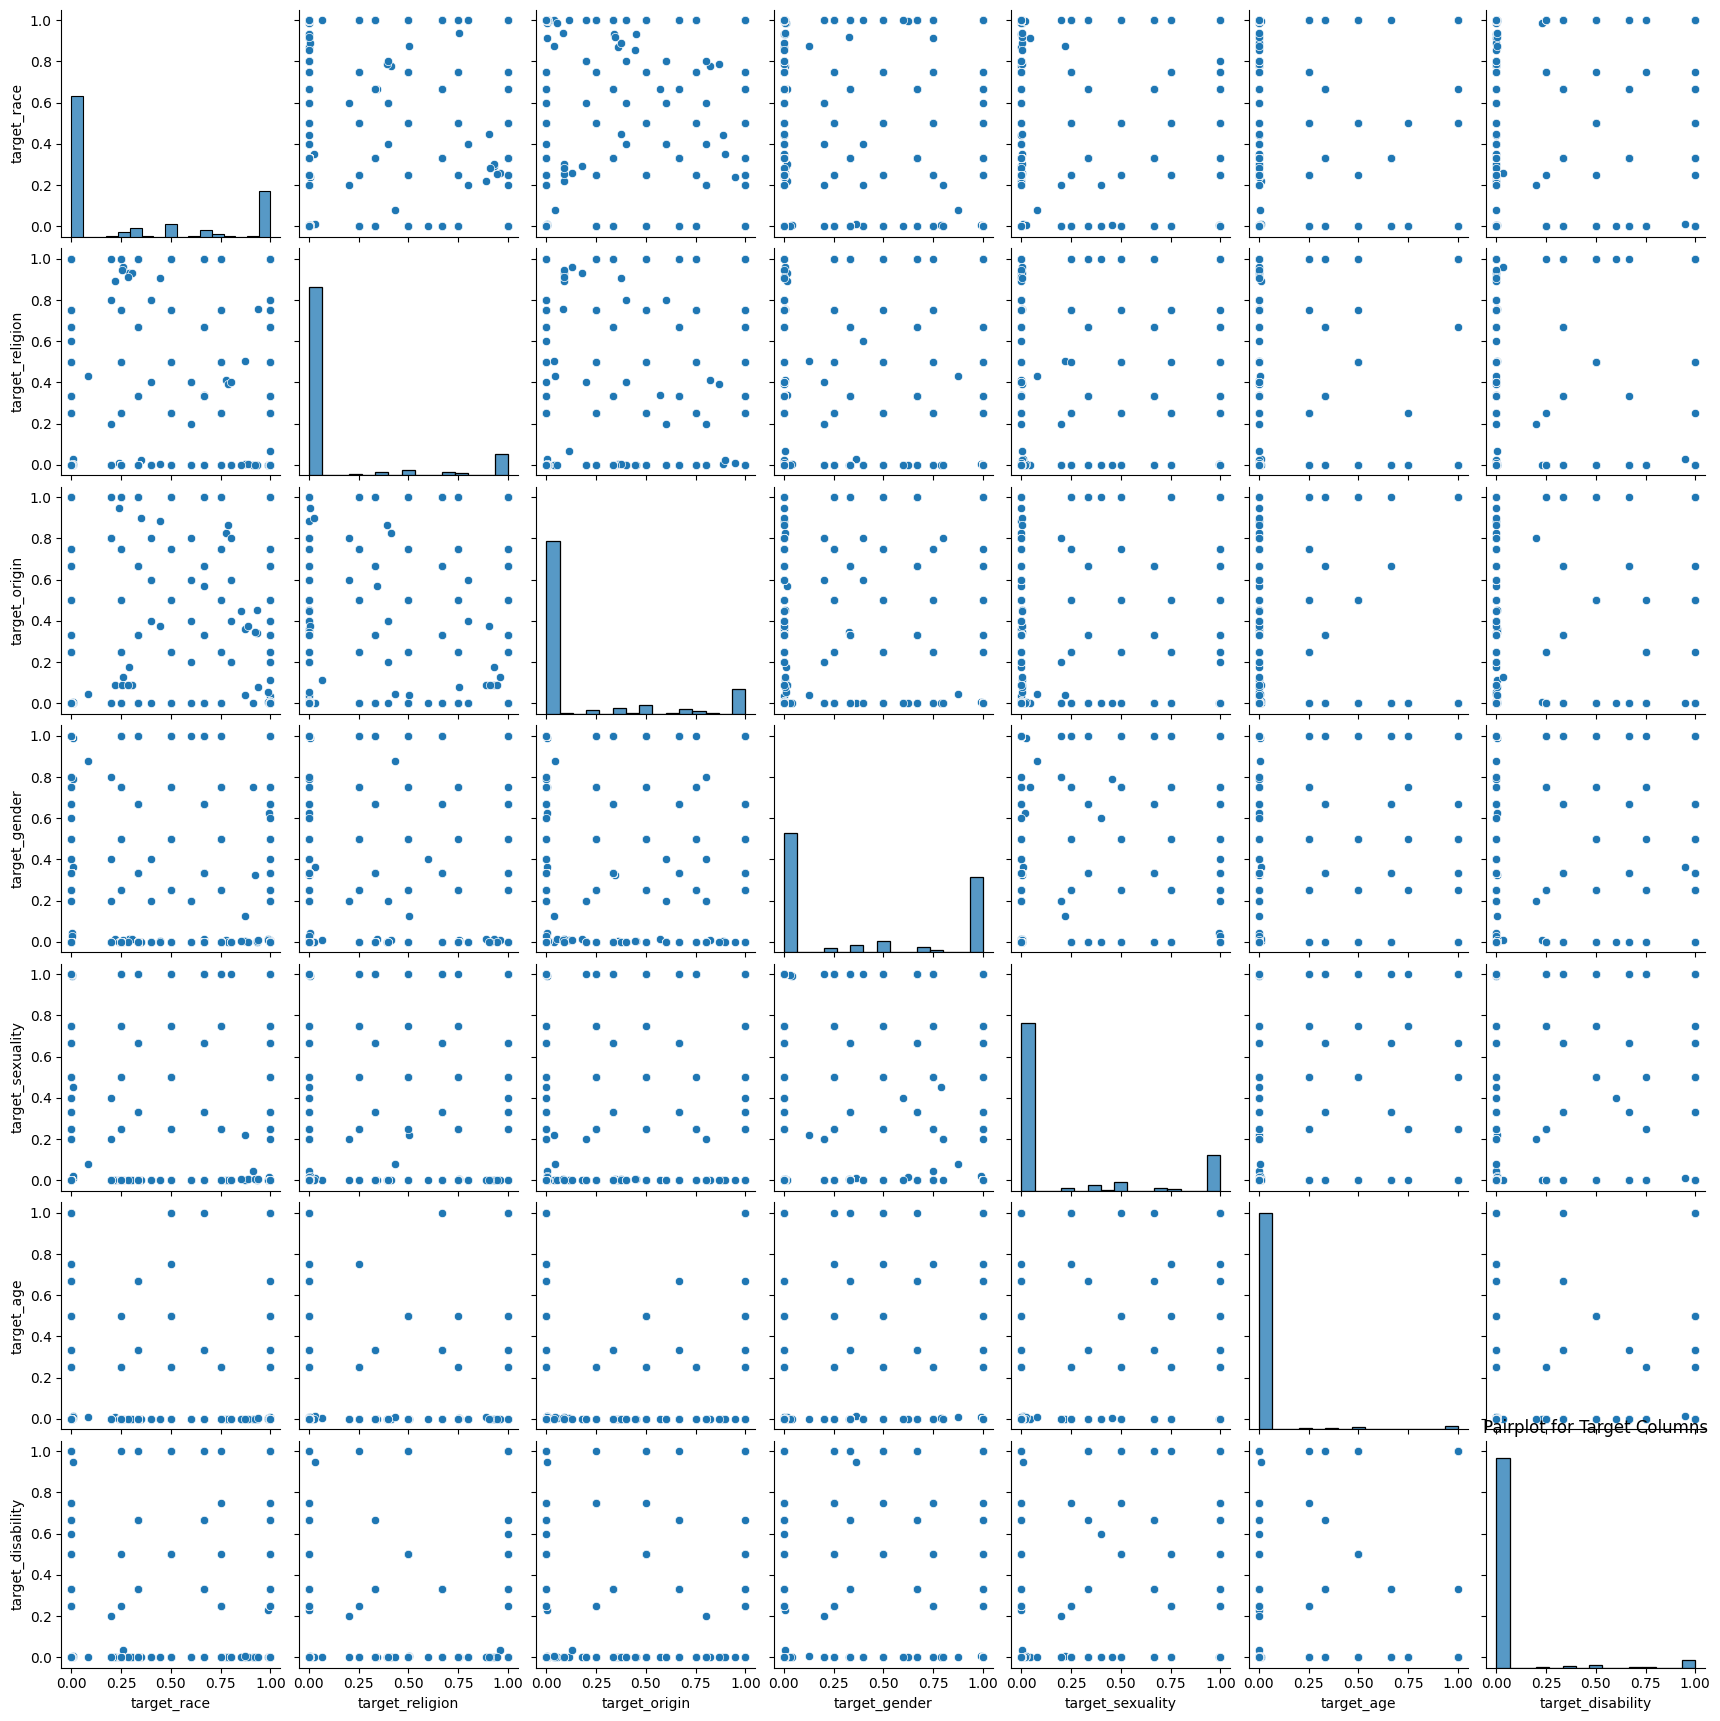

In [17]:
inspect_for_cor(filtered_df, target_cols_lvl1, 'Target Columns')

# 3. Models

### 3.0 Function & Class definitions

In [18]:
def append_results(results: list, report: dict, model_name: str, metrics: list[str]):
    
    append_dict = {}

    for metric in metrics:
        append_dict[f'{metric}_hate'] = report['1'][metric]
        append_dict[f'{metric}_non_hate'] = report['0'][metric]
        append_dict[f'{metric}_macro_avg'] = report['macro avg'][metric]
        append_dict[f'{metric}_weighted_avg'] = report['weighted avg'][metric]

    append_dict['accuracy'] = report['accuracy']

    results.append({
        'model': model_name,
        **append_dict
    })

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def bow_preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

def stream_batches(texts, labels, batch_size=32, max_length=256):
    """
    Streams batches into SGD classifier

    Args:
        texts (pd.Series): The texts to stream
        labels (pd.Series): The labels to stream
        batch_size (int): The batch size
        max_length (int): The maximum length of the texts
    
    Returns:
        generator: A generator of batches
    """
    n = len(texts)
    n_batches = ceil(n / batch_size)

    # Iterate over the batches to yield them one by one
    for i in range(n_batches):
        batch_texts = texts.iloc[i*batch_size:(i+1)*batch_size].tolist()
        batch_labels = labels.iloc[i*batch_size:(i+1)*batch_size].values
        
        # dynamic padding + truncation
        enc = bert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        yield enc["input_ids"], enc["attention_mask"], batch_labels


In [19]:
class BOWTextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(bow_preprocess)

### 3.1. BoW + Logistic Regression

In [ ]:
# Dataframe for Bag of Words (BoW) representation
bow_df = filtered_df.copy()

# Releveant columns
bow_cols = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[bow_cols]


In [ ]:
label_counts = bow_df['is_hate_speech'].value_counts()
label_percentage = bow_df['is_hate_speech'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)
print("\nLabel Percentage Distribution:")
print(label_percentage)

##### 3.1.1 Data preprocessing

TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [ ]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



In [ ]:
bow_pipeline = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [ ]:
X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)


##### 3.1.2. Fit model to training set - BoW + LogReg

In [ ]:
# Fit the pipeline to the training data
bow_pipeline.fit(X_train, y_train)


In [ ]:
# Make predictions on the test set
y_pred_bow = bow_pipeline.predict(X_test)

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

In [ ]:
append_results(results, report_bow, 'BoW + LogisticRegression', EVALUATION_METRICS)

### 3.2 TF-IDF + Logistic Regression

In [ ]:
pipeline_tfidf = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

In [ ]:
append_results(results, report_tfidf, 'TF-IDF + LogisticRegression', EVALUATION_METRICS)

##### 3.2.2 Hyperparameter tuning with GridSearchCV

In [ ]:
pipeline_tuned = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # or CountVectorizer()
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed to compare L1 and L2
}

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=3, 
    scoring='f1', 
    verbose=2, 
    n_jobs=1
)

grid_search.fit(X_train, y_train)

In [ ]:

print("Best params:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Use best model to predict test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

append_results(results, report_tuned, 'Tuned BoW + LogisticRegression', EVALUATION_METRICS)



### 3.3. BERT + Logistic Regression

##### 3.3.1. Load model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
bert_tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)



In [ ]:
bert_df = filtered_df.copy()

# Optional: Take a subset to ease computational load
bert_df = bert_df.sample(frac=1)

X = bert_df['text']
y = bert_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)

batch_size = 16
num_batches = ceil(len(X_train) / batch_size)



Computing class weights for the balance_weight argument in partial fit (TODO: remove this and "class weight" argument from model instantiation if we decide to do under/oversampling instead)

In [ ]:
# classes must match what you’ll pass to partial_fit
classes = np.array([0, 1])

# Compute: this returns an array [w_for_0, w_for_1]
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train,             # your full training-label vector
)

# Turn it into a dict: { class_label: weight, … }
class_weight_dict = {c: w for c, w in zip(classes, weights)}

In [ ]:
# Instantiate SGD-based logistic regression
clf = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1, warm_start=True, class_weight=class_weight_dict)
classes = [0, 1]          
first_batch = True

train_iter = tqdm(
    stream_batches(X_train, y_train, batch_size=batch_size),
    total=num_batches,
    desc="Training"
)


# Loop (stream) through training data
first_batch = True
for input_ids, attn_mask, y_batch in train_iter:

    # Get the features from the model
    with torch.no_grad():
        out = model(input_ids, attention_mask=attn_mask)

    # pull out the [CLS] token embedding for each example
    feats = out.last_hidden_state[:,0,:].cpu().numpy()
    
    if first_batch:
        # partial_fit needs to see the 'classes' array at first call
        clf.partial_fit(feats, y_batch, classes=classes)
        first_batch = False
    else:
        clf.partial_fit(feats, y_batch)
    

# Evaluate on tast data, with streaming
all_preds = []
all_labels = []

# Iterate over the test data
for input_ids, attn_mask, y_batch in stream_batches(X_test, y_test, batch_size=16):

    # Get the features from the model
    with torch.no_grad():
        out = model(input_ids, attention_mask=attn_mask)
    feats = out.last_hidden_state[:,0,:].cpu().numpy()

    # Predict the labels
    preds = clf.predict(feats)
    
    # Save
    all_preds.append(preds)
    all_labels.append(y_batch)

# flatten and compute metric
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)


In [ ]:
report_distilbert = classification_report(y_true, y_pred, output_dict=True)
append_results(results, report_distilbert, 'BERT + LogisticRegression', EVALUATION_METRICS)

# 4. Evaluation

In [20]:
results_df = pd.DataFrame(results)

results_df

""


# 5. LLM

In [21]:
llm_df = filtered_df[['text', 'is_hate_speech']].copy()

llm_df

,text,is_hate_speech
0,White people are trash.,0
1,"You've caught the big gay, it's known to be ai...",0
2,"I'm not saying you said that, I'm just saying ...",0
3,Donald Trump. Yeet myself off a building onto ...,0
4,Fabrice Fabrice is ostensibly black or black/l...,0
...,...,...
39560,Good you Americans are annoying asf. I Wish mo...,1
39561,Go to streets of the USA and our kids and vets...,1
39562,That Kenyan girl is gorgeous!,0
39563,Yikes!!! Bad enough she'shard to look at.every...,1


In [22]:
train_df, test_df = train_test_split(llm_df, test_size=0.2, random_state=42, stratify=llm_df.is_hate_speech)

## 5.1  Setting up the prompts

### 5.1.1 Simple zero shopt prompting

In [23]:
zero_shot_template = (
    "Decide whether the following text is hate speech. "
    "Respond only with “yes” or “no”.\n\n"
    "Text: \"{text}\"\n"
)

### 5.1.2 Few Shot

In [24]:
few_shot_examples = [
    ("This is how you fuck a sissy bimbo slut. Hard and rough 💋", "yes"), # Just above the threshold
    ("I hate you little ass fuckboys. Y'all need a real father figure in your lives to beat your faggot asses when y'all do dumb disrespectful shit for clout. God damn I wish there was a whole genocide of you fuckboys.", "yes"), # A LOT above the threshold
    ("Fuck this bitch she deserves the death sentence", "yes") # In between the threshold and 1
]

few_shot_template = "Decide whether each of the following texts is hate speech (yes/no).\n\n"
for txt, label in few_shot_examples:
    few_shot_template += f"Text: \"{txt}\"\nLabel: {label}\n\n"
few_shot_template += "Text: \"{text}\"\nLabel:"

### 5.1.3 Chain of Thought

In [25]:
cot_1_template = (
    "You are a hate speech detection expert. For each message, follow the structured reasoning process below to determine whether it constitutes hate speech. "
    "At the end, provide your decision as \"yes\" if the message is hate speech or \"no\" if it is not.\n\n"
    "Step-by-step reasoning:\n"
    "1. Check for identity group targeting\n"
    "   • Does the message reference a protected identity group (e.g., race, religion, gender, nationality, sexual orientation, disability)?\n"
    "   • Is the comment directed at that group or an individual as a member of such a group?\n"
    "2. Evaluate harmful content components:\n"
    "   Assess whether the message contains any of the following (in increasing severity):\n"
    "   • Bias (e.g., prejudice, stereotypes)\n"
    "   • Hostility (e.g., slurs, insults, profanity)\n"
    "   • Dehumanization (e.g., comparing people to animals, diseases)\n"
    "   • Threats of violence or emotional abuse\n"
    "   • Support for genocide or extermination\n"
    "3. Consider positive or neutral alternatives:\n"
    "   • Is the message neutral or descriptive without showing prejudice or hostility?\n"
    "   • Is it supportive or expressing solidarity with an identity group?\n"
    "   • Does it counter existing hate speech in a respectful and reasoned way?\n"
    "4. Disambiguate sarcasm or coded language:\n"
    "   • If language is ambiguous, check for slurs (even covert or coded ones).\n"
    "   • Determine whether the tone masks underlying hostility.\n"
    "5. Make a decision:\n"
    "   • If the message expresses bias, hostility, dehumanization, violence, or genocide, label as \"yes\" (hate speech).\n"
    "   • If the message is neutral, supportive, or counters hate, label as \"no\" (not hate speech).\n\n"
    "Text: \"{text}\"\n\n"
)

In [26]:
col_2_template = (
    "You are an expert annotator trained on nuanced hate speech labels. For each message, reason carefully before deciding if it is hate speech. "
    "Use the following steps to guide your judgment. At the end, output a single word: \"yes\" if the message is hate speech, \"no\" if it is not.\n\n"
    "1. Identity reference\n"
    "Does the message mention a protected identity group (race, religion, gender, sexual orientation, nationality, disability)?\n"
    "If yes, continue. If no, likely not hate speech unless violence is generalized.\n\n"
    "2. Generalized hostility or ideological hate\n"
    "Does the message express hate, blame, or violent wishes against an entire identity group?\n"
    "Does it dehumanize, wish suffering, or accuse them collectively of wrongdoing?\n"
    "→ This is stronger evidence of hate speech.\n\n"
    "3. Personal insults or interpersonal aggression\n"
    "Is the message aimed at a specific person (e.g., \"bitch\", \"dumbass\") but not making generalized claims about their group?\n"
    "Does it use common online slang, bravado, or insult without ideology or group targeting?\n"
    "→ This is not usually hate speech. May be offensive, but not hateful by intent.\n\n"
    "4. Violent language\n"
    "Does it involve actual or implied threats against a person or group? Is the threat based on identity (e.g., religion, sexual orientation)?\n"
    "→ Threats tied to identity increase severity.\n\n"
    "5. Slang, coded language, or satire\n"
    "Does it use community-specific slang or cultural expressions? Could it be sarcastic, ironic, or hyperbolic?\n"
    "→ Be cautious. Don’t interpret slang or exaggeration literally unless hate is clear.\n\n"
    "6. Final judgment\n"
    "If the message attacks or threatens an identity group, or promotes violence or dehumanization against them → yes.\n"
    "If the message contains personal insults, edgy language, or group-neutral ranting, → no.\n\n"
    "Text: \"{text}\"\n\n"
)

## 5.2 Model setup

### 5.2.1 OpenAI - gpt-4.1-nano

Link to docs: https://platform.openai.com/docs/overview

Link to usage tracking: https://platform.openai.com/settings/organization/usage

In [27]:
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Retrieve the API key from the .env file
api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client with the API key
openai_client = OpenAI(api_key=api_key)

def _classify_openai(prompt: str) -> str:
    resp = openai_client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_completion_tokens=60
    )
    return resp.choices[0].message.content.strip().lower()

### 5.2.2 DeepSeek - R1 Distill Qwen 1.5B

Using the small distilled version as it can run on CPU

Link to HF 🤗: https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

In [28]:
# — DeepSeek-R1 (Hugging Face) setup —
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_ds = AutoTokenizer.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    trust_remote_code=True
)
model_ds = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    trust_remote_code=True,
    device_map="cpu"
)

def _classify_deepseek(prompt: str) -> str:
    inputs  = tokenizer_ds(prompt, return_tensors="pt").to(model_ds.device)
    outputs = model_ds.generate(
        **inputs,
        max_new_tokens=60,
        do_sample=False,
        pad_token_id=tokenizer_ds.eos_token_id,
    )
    gen     = tokenizer_ds.decode(
        outputs[0][ inputs.input_ids.shape[-1] : ],
        skip_special_tokens=True
    )
    return gen.strip().lower()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


### 5.2.3 xAI - Grok 3 mini

Link to docs: https://docs.x.ai/docs/tutorial (note this is similar if not the same as for OpenAI's models)

Link to usage tracking: https://console.x.ai/team/c571d3a4-3c67-47c9-bc1d-9b90fbeb19a5/usage

In [29]:
load_dotenv()

grok_client = OpenAI(
  api_key = os.getenv("GROK_API_KEY"),
  base_url="https://api.x.ai/v1",
)

def _classify_grok(prompt: str) -> str:
    resp = grok_client.chat.completions.create(
        model="grok-3-mini",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.0,
        max_completion_tokens=60
    )
    return resp.choices[0].message.content.strip().lower()

## 5.3 Choose the model you want to continue with

🚨 **Do so by changing the LLM_BACKEND variable underneath** 🚨

In [30]:
LLM_BACKEND = "openai"   # or "deepseek" or "grok"

def classify_with_llm(prompt: str) -> str:
    if LLM_BACKEND == "openai":
        return _classify_openai(prompt)
    elif LLM_BACKEND == "deepseek":
        return _classify_deepseek(prompt)
    elif LLM_BACKEND == "grok":
        return _classify_grok(prompt)
    else:
        raise ValueError(f"Unknown LLM backend: {LLM_BACKEND}")

## 5.4 Individual testing

In [31]:
def classify_comment(text: str, method: str = "zero") -> str:
    """
    Classify a single comment as hate speech (“yes”/“no”) using one of:
      – “zero” : zero-shot prompting
      – “few”    : few-shot prompting
      – “cot”    : chain-of-thought prompting
    """
    if method == "zero":
        template = zero_shot_template
    elif method == "few":
        template = few_shot_template
    elif method == "cot":
        template = cot_template
    else:
        raise ValueError(f"Unknown method: {method}")

    prompt = template.format(text=text)
    out    = classify_with_llm(prompt)
    return "yes" if "yes" in out else "no"

def test_comment():
    """
    Prompt the user for a comment, echo it, and show all three classifications.
    """
    comment = input("Enter a comment to classify: ")
    print(f"\nComment to classify: \"{comment}\"\n")

    for method, label in [
        ("zero", "Zero-shot prompting"),
        ("few",    "Few-shot prompting"),
        ("cot",    "Chain-of-Thought prompting")
    ]:
        pred = classify_comment(comment, method=method)
        print(f"{label:25}: {pred}")

import time

def test_comment_timed():
    """
    Prompt the user for a comment, echo it, then for each method:
    – time how long classify_comment takes
    – print both the prediction and the time elapsed
    """
    comment = input("Enter a comment to classify: ")
    print(f"\nComment to classify: \"{comment}\"\n")

    for method, label in [
        ("zero", "Zero-shot prompting"),
        ("few",    "Few-shot prompting"),
        ("cot",    "Chain-of-Thought prompting")
    ]:
        start = time.perf_counter()
        pred  = classify_comment(comment, method=method)
        end   = time.perf_counter()
        elapsed = end - start
        print(f"{label:25}: {pred:<3}  (took {elapsed:.2f} s)")

In [ ]:
# test_comment_timed()

## 5.5 Run classification on larger datasets

In [32]:
# Sample 50 from each class
sample_0 = llm_df[llm_df['is_hate_speech'] == 0].sample(n=500, random_state=42)
sample_1 = llm_df[llm_df['is_hate_speech'] == 1].sample(n=500, random_state=42)

# Concatenate and shuffle
sample_df = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [33]:
def run_classification(df, template_fn, classify_fn):
    preds = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        prompt = template_fn.format(text=row.text)
        out    = classify_fn(prompt)
        preds.append("yes" if "yes" in out else "no")
    return np.array(preds)

# Example: assuming `sample_df` is defined
simple_preds   = run_classification(sample_df, zero_shot_template, classify_with_llm)
few_shot_preds = run_classification(sample_df, few_shot_template, classify_with_llm)
cot_preds      = run_classification(sample_df, col_2_template, classify_with_llm)

100%|██████████| 1000/1000 [22:10<00:00,  1.33s/it]


## 5.6 Results

In [34]:
# 1. Prepare a fresh llm_results list
llm_results = []

# 2. Pull the true labels from your real column
y_true = sample_df['is_hate_speech'].values

# 3. A tiny helper to turn your “yes”/“no” preds into 1/0
def to_numeric(preds):
    return np.array([1 if p == 'yes' else 0 for p in preds])

# 4. Run each of your LLM classifiers (you already have these arrays)
y_simple = to_numeric(simple_preds)
y_few   = to_numeric(few_shot_preds)
y_cot   = to_numeric(cot_preds)

# 5. Build a classification report for each and append to llm_results
report_simple = classification_report(y_true, y_simple, output_dict=True)
append_results(llm_results, report_simple, 'LLM simple prompt', EVALUATION_METRICS)

report_few = classification_report(y_true, y_few, output_dict=True)
append_results(llm_results, report_few, 'LLM few-shot prompt', EVALUATION_METRICS)

report_cot = classification_report(y_true, y_cot, output_dict=True)
append_results(llm_results, report_cot, 'LLM chain-of-thought prompt', EVALUATION_METRICS)

In [35]:
llm_results_df = pd.DataFrame(llm_results)
llm_results_df

,model,precision_hate,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_hate,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg,accuracy
0,LLM simple prompt,0.726655,0.824818,0.775736,0.775736,0.856,0.678,0.767,0.767,0.786042,0.744237,0.765140,0.765140,0.767
1,LLM few-shot prompt,0.723368,0.811005,0.767186,0.767186,0.842,0.678,0.760,0.760,0.778189,0.738562,0.758375,0.758375,0.760
2,LLM chain-of-thought prompt,0.526214,0.527835,0.527024,0.527024,0.542,0.512,0.527,0.527,0.533990,0.519797,0.526894,0.526894,0.527


In [36]:
# 1. Copy your sample (or full test) DataFrame
comp_df = sample_df.copy()

# 2. Add numeric preds
comp_df['pred_simple'] = to_numeric(simple_preds)
comp_df['pred_few']    = to_numeric(few_shot_preds)
comp_df['pred_cot']    = to_numeric(cot_preds)

# 3. (Optional) turn 0/1 back into yes/no strings
comp_df['pred_simple_str'] = np.where(comp_df['pred_simple']==1, 'yes', 'no')
comp_df['pred_few_str']    = np.where(comp_df['pred_few']==1,    'yes', 'no')
comp_df['pred_cot_str']    = np.where(comp_df['pred_cot']==1,    'yes', 'no')

# 4. Rename your true‐label column to something easy
comp_df = comp_df.rename(columns={'is_hate_speech': 'true_label'})

# 5. See the full thing
comp_df[['text', 'true_label',
               'pred_simple_str', 'pred_few_str', 'pred_cot_str']]

,text,true_label,pred_simple_str,pred_few_str,pred_cot_str
0,@NihaMasih When you have jihadis writing for w...,1,yes,yes,no
1,I suddenly feel a lot better about that bus of...,1,no,yes,no
2,Buncha fags.,1,yes,yes,yes
3,Can your white supremacist ass go get fucked w...,1,yes,no,yes
4,@helper2 When are they going to do something t...,0,yes,yes,yes
...,...,...,...,...,...
995,"""God damn, I can't wait to bury my monster coc...",0,no,yes,no
996,"Wow. Thank you, @ArianaGrande for not being af...",0,no,no,no
997,if you make a Nigga cum off head you the devil,1,yes,yes,yes
998,Do they realize that a random Japanese person ...,0,no,no,yes


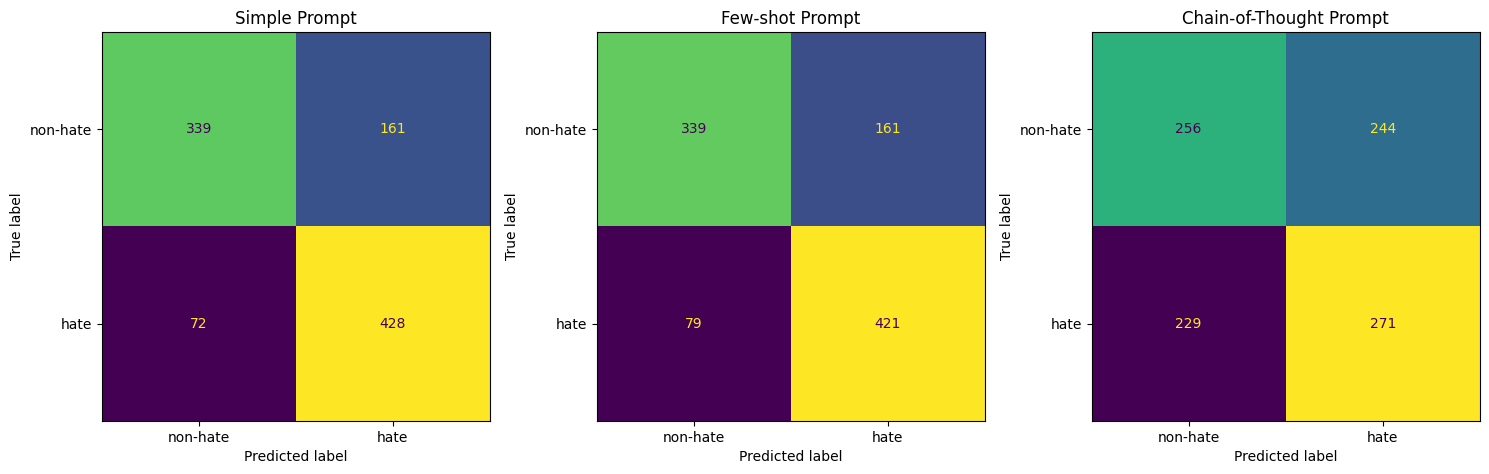

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrices
cm_simple = confusion_matrix(comp_df['true_label'], comp_df['pred_simple'])
cm_few    = confusion_matrix(comp_df['true_label'], comp_df['pred_few'])
cm_cot    = confusion_matrix(comp_df['true_label'], comp_df['pred_cot'])

# Set up the plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display each confusion matrix
disp_simple = ConfusionMatrixDisplay(cm_simple, display_labels=['non-hate', 'hate'])
disp_simple.plot(ax=axs[0], colorbar=False)
axs[0].set_title('Simple Prompt')

disp_few = ConfusionMatrixDisplay(cm_few, display_labels=['non-hate', 'hate'])
disp_few.plot(ax=axs[1], colorbar=False)
axs[1].set_title('Few-shot Prompt')

disp_cot = ConfusionMatrixDisplay(cm_cot, display_labels=['non-hate', 'hate'])
disp_cot.plot(ax=axs[2], colorbar=False)
axs[2].set_title('Chain-of-Thought Prompt')

plt.tight_layout()
plt.show()